In [5]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.signal import find_peaks as fp
from sklearn import preprocessing
from lmfit.models import LorentzianModel, QuadraticModel, LinearModel

In [6]:
def create_directory(directory):
    try:
        os.mkdir(directory)
        print(f"Directory '{directory}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


def process_data(data_folder):
    '''
    RAW DATA EXCTRACTION.
    '''
    print('Initializing data processing.')
    
    directory_processed_data = '../data/processed_data/' + data_folder
    create_directory(directory_processed_data)
            
    raw_data_list = np.array(list(Path('../data/raw_data/' + data_folder).rglob('*.txt')))
    #print(raw_data_list)
    print('A total of '+ str(len(raw_data_list)) + ' data files have been found to process.')
    
    for file_path in raw_data_list:
        df_raw = pd.read_csv(file_path, sep='\t', names=['shift','intensity'], index_col = 'shift')

        #fig0 = plt.figure(figsize=(20,5))
        #ax = fig0.add_subplot(1,1,1)
        #ax.plot(df_raw,linewidth=1,label='Graphene Spectra')
        #ax.grid()
        #ax.set_ylabel('Intensity [arbs]')
        #ax.set_xlabel('Raman Shift [cm^-1]')
        #ax.set_title(filename + '_raw')
        #ax.legend()
        #plt.show()
    
        '''
        NOISE CLEARING.
        To perform proper analysis on the RAMAN spectrum, it is necessary to perform noise cleaning on the raw data.
        This cleaning includes silicon spectrum subtraction, analysis range limits, normalization and signal smoothing.
        '''
        # Spectral Substraction of Silicon
        df_reference =  pd.read_csv('../data/spectra_reference_graphene.txt', sep='\t', names=['shift','intensity'], index_col = 'shift')
        df = df_raw - df_reference 

        # Shift Range Reduction
        upper_bound = 3500
        lower_bound = 1000
        df = df.loc[lower_bound:upper_bound]

        # Normalization
        df = (df - df.min())/abs(df.max())

        # Save Clean Data
        df.to_csv(Path(directory_processed_data + '/' + os.path.basename(file_path)[:-4] + '_noiseless.txt'),sep='\t', index=True, header = False)
        
        #fig1 = plt.figure(figsize=(20,5))
        #ax = fig1.add_subplot(1,1,1)
        #ax.plot(df,linewidth=1,label='Graphene Spectra')
        #ax.grid()
        #ax.set_ylabel('Intensity [normalized]')
        #ax.set_xlabel('Raman Shift [cm^-1]')
        #ax.set_title(filename + '_noisless')
        #ax.legend()
        #plt.show()
    
    processed_data_list = np.array(list(Path(directory_processed_data).rglob('*.txt')))
    #print(processed_data_list)
    print('A total of '+ str(len(processed_data_list)) + ' data files have been processed.')

In [7]:
def add_peak(prefix, center, amplitude=0.05, sigma=0.5):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars

def find_peaks(df, height = 0.025, prominence = 0.04, distance = 10):
    p, _ = fp(x=df.intensity,height = height, prominence = prominence, distance = distance)
    peaks = df.iloc[p]
    n = len(peaks) # total peaks found
    return n, peaks

    #fig2 = plt.figure(figsize=(20,5))
    #ax = fig2.add_subplot(1,1,1)
    #ax.plot(df,linewidth=1,label='Graphene Spectra')
    #ax.scatter(peaks.index.values,peaks)
    #ax.grid()
    #ax.set_ylabel('Intensity [normalized]')
    #ax.set_xlabel('Raman Shift [cm^-1]')
    #ax.set_title(filename + '_noiseless_peaks')
    #ax.legend()
    #plt.show()

def analyze_data(data_folder, time_limit=60):
    print('Initializing data analysis.')
    # Create directories
    directory_fit_report = '../data/fit_reports/' + data_folder
    directory_graphs_data = '../data/graphs_data/' + data_folder
    create_directory(directory_fit_report)
    create_directory(directory_graphs_data)

    '''
    LORENTZ FITTING.
    '''
    processed_data_list = np.array(list(Path('../data/processed_data/' + data_folder).rglob('*.txt')))
    #print(processed_data_list)
    print('A total of '+ str(len(processed_data_list)) + ' data files have been found to analyze.')
    print('Initializing Lorentzian fitting.')
    count = 0
    for file_path in processed_data_list:        
        #progress bar
        sys.stdout.write('\r')
        sys.stdout.write("[%-s] %d%%" % ('='*count, 100/len(processed_data_list)*count))
        sys.stdout.write(' - [' + str(file_path)+']')
        sys.stdout.flush()
        
        df = pd.read_csv(file_path, sep='\t', names=['shift','intensity'], index_col = 'shift')
        xData, yData = np.loadtxt(file_path, unpack= True)
        
        n, peaks = find_peaks(df)
        
        model = LinearModel(prefix='bkg_')
        params = model.make_params(a=0, b=0, c=0)

        rough_peak_positions = peaks.index.values
        for i, cen in enumerate(rough_peak_positions):
            peak, pars = add_peak('lz%d_' % (i+1), cen)
            model = model + peak
            params.update(pars)
            
        init = model.eval(params, x=xData)
        result = model.fit(yData, params, x=xData)
        comps = result.eval_components()
        report = result.fit_report(min_correl=0.5)

        f = open(directory_fit_report + '/' + os.path.basename(file_path)[:-4] + '_fit_report.txt', 'w') #save report as txt
        f.write(report)
        f.close()
        #print(report)
        count += 1

        '''
        GRAPHING
        '''
        fig3 = plt.figure(figsize=(20,18))
        ax = fig3.add_subplot(3,1,3)
        bx = fig3.add_subplot(3,1,2)
        cx = fig3.add_subplot(3,1,1)

        for sp in (ax,bx,cx):
            sp.plot(df,linewidth=1,label='Graphene Spectra') # experimental data
            sp.scatter(peaks.index.values,peaks) # peaks fitting

        for name, comp in comps.items():
            ax.plot(xData,comp, '--',linewidth=1,label=name,alpha = 1.0) 
            ax.fill_between(xData, comp, '--', alpha=.2, label=name + 'fill')
    
        bx.plot(xData, result.best_fit, label='Lorentz fitting (best fit)', alpha=1.0)
        bx.fill_between(xData, result.best_fit,label='Lorentz fitting fill', alpha=.2)

        for sp in (ax,bx,cx):
            sp.grid()
            sp.set_ylabel('Intensity [normalized]')
            sp.set_xlabel('Raman Shift [cm^-1]')
            sp.legend()
           
        
        ax.set_title(os.path.basename(file_path)[:-4] + '_lorentz_fitting_splitted')
        bx.set_title(os.path.basename(file_path)[:-4] + '_lorentz_fitting')
        cx.set_title(os.path.basename(file_path)[:-4] + '_noiseless_peaks')

        plt.savefig(directory_graphs_data + '/' + os.path.basename(file_path)[:-4] + '_fit_graphs.png') #save graphs as png
        #plt.show()
    
    fit_report_list = np.array(list(Path(directory_fit_report).rglob('*.txt')))
    print(fit_report_list)
    print('A total of '+ str(len(fit_report_list)) + ' data files have been analyzed.')

Initializing data processing.
Directory '../data/processed_data/20241112_data_LUCE_ICAT' already exists.
A total of 22 data files have been found to process.
A total of 22 data files have been processed.
Initializing data analysis.
Directory '../data/fit_reports/20241112_data_LUCE_ICAT' already exists.
Directory '../data/graphs_data/20241112_data_LUCE_ICAT' already exists.
A total of 22 data files have been found to analyze.
Initializing Lorentzian fitting.
[=========] 40% - [..\data\processed_data\20241112_data_LUCE_ICAT\Muestra 1_100x_zona3_verde_noiseless.txt]

KeyboardInterrupt: 

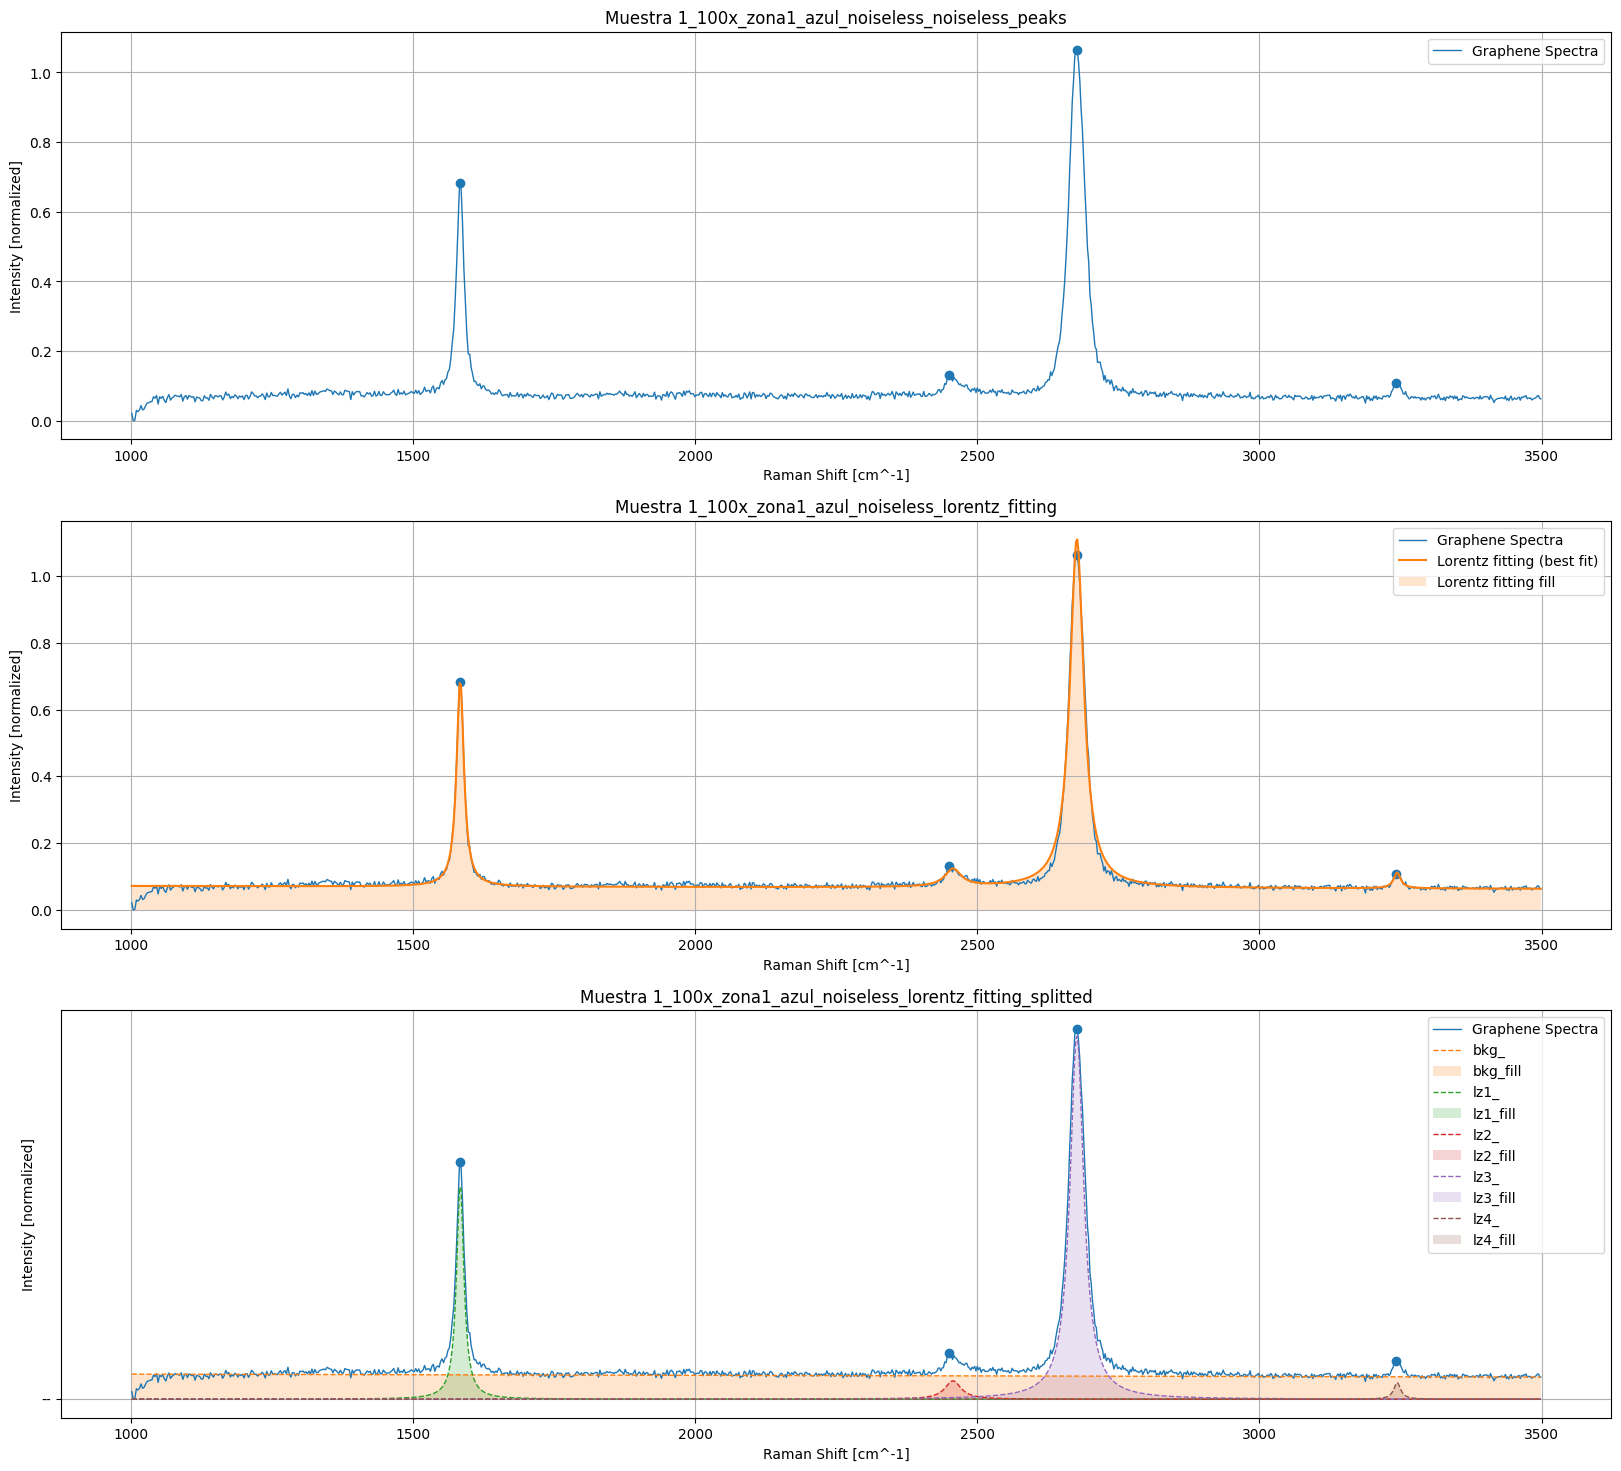

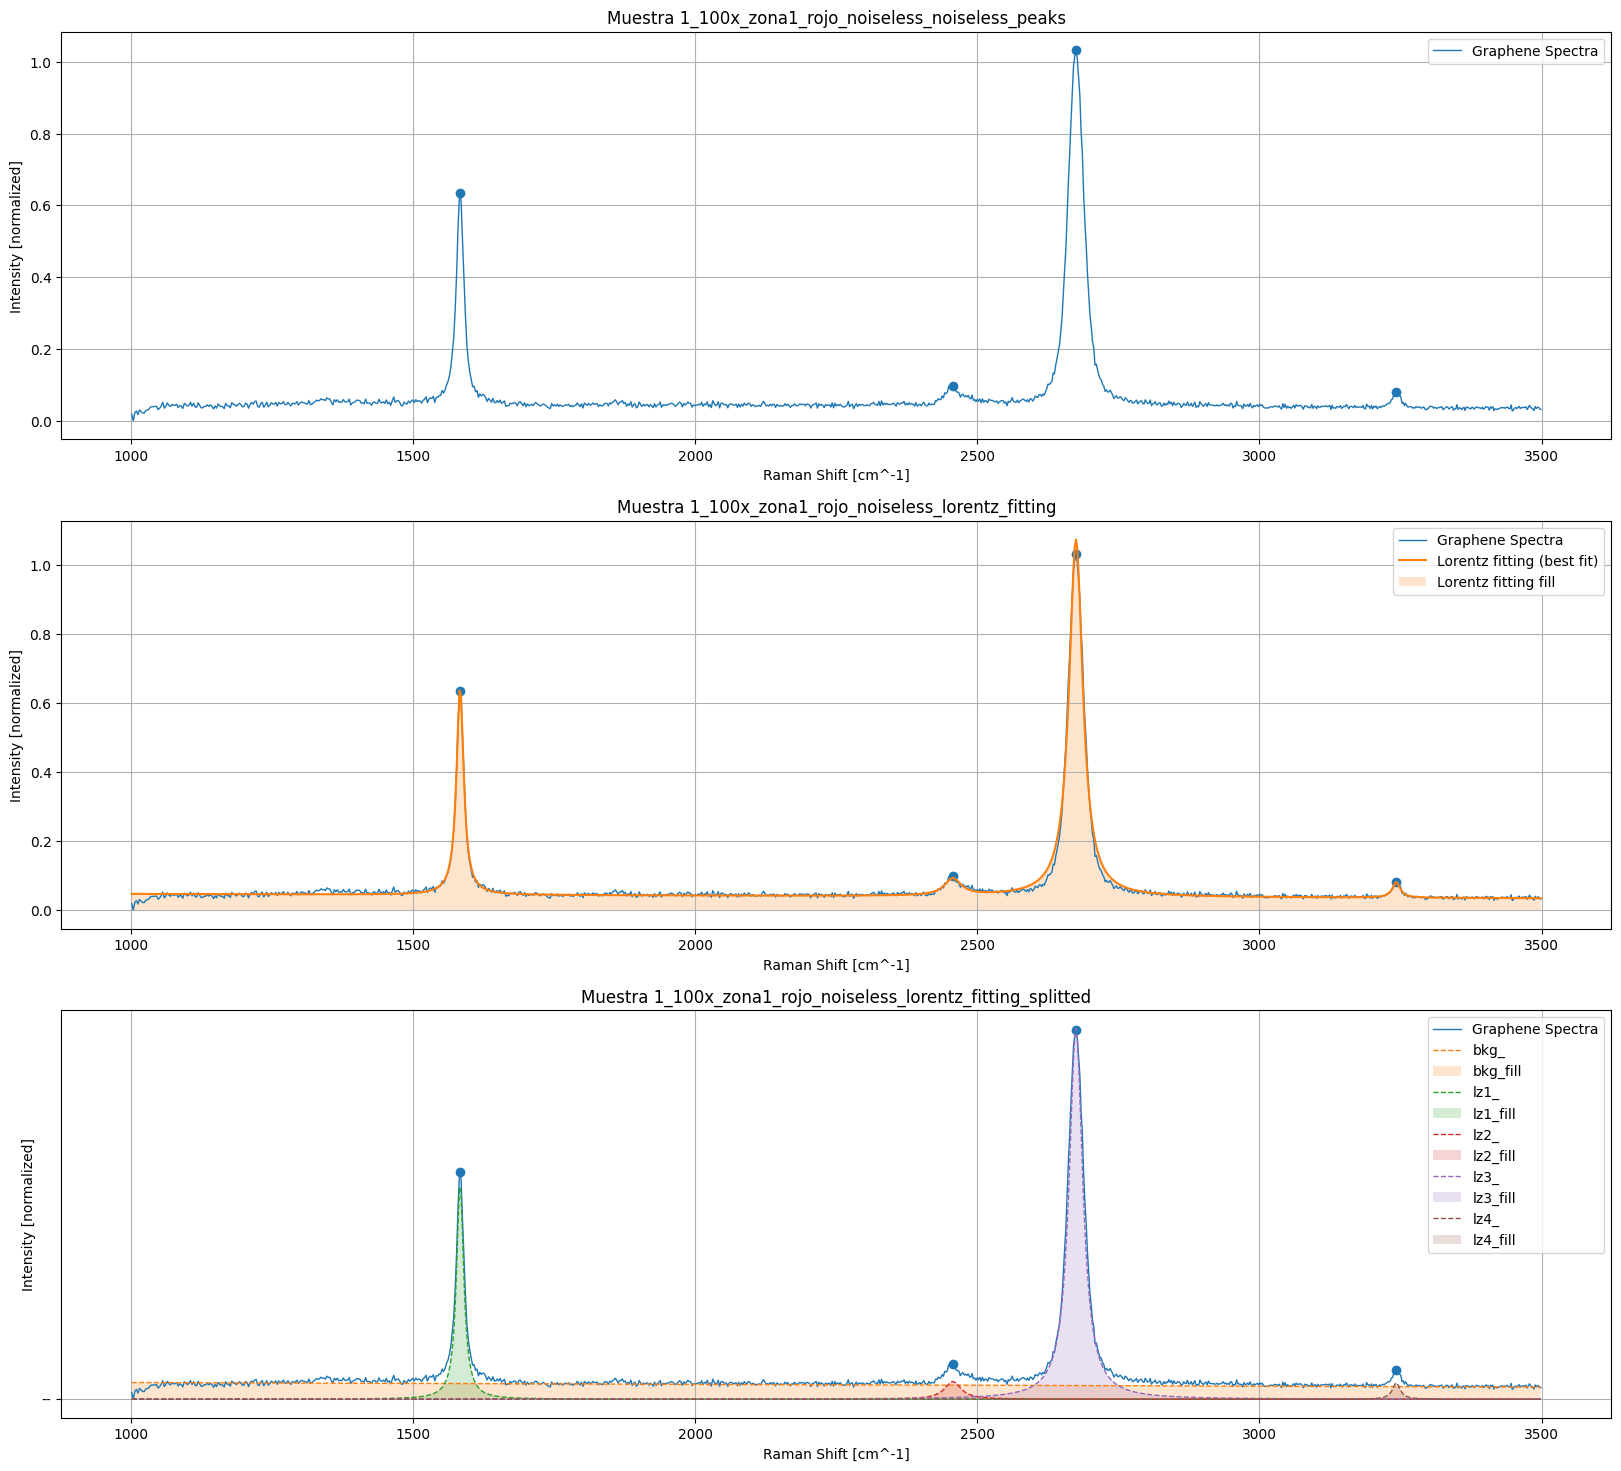

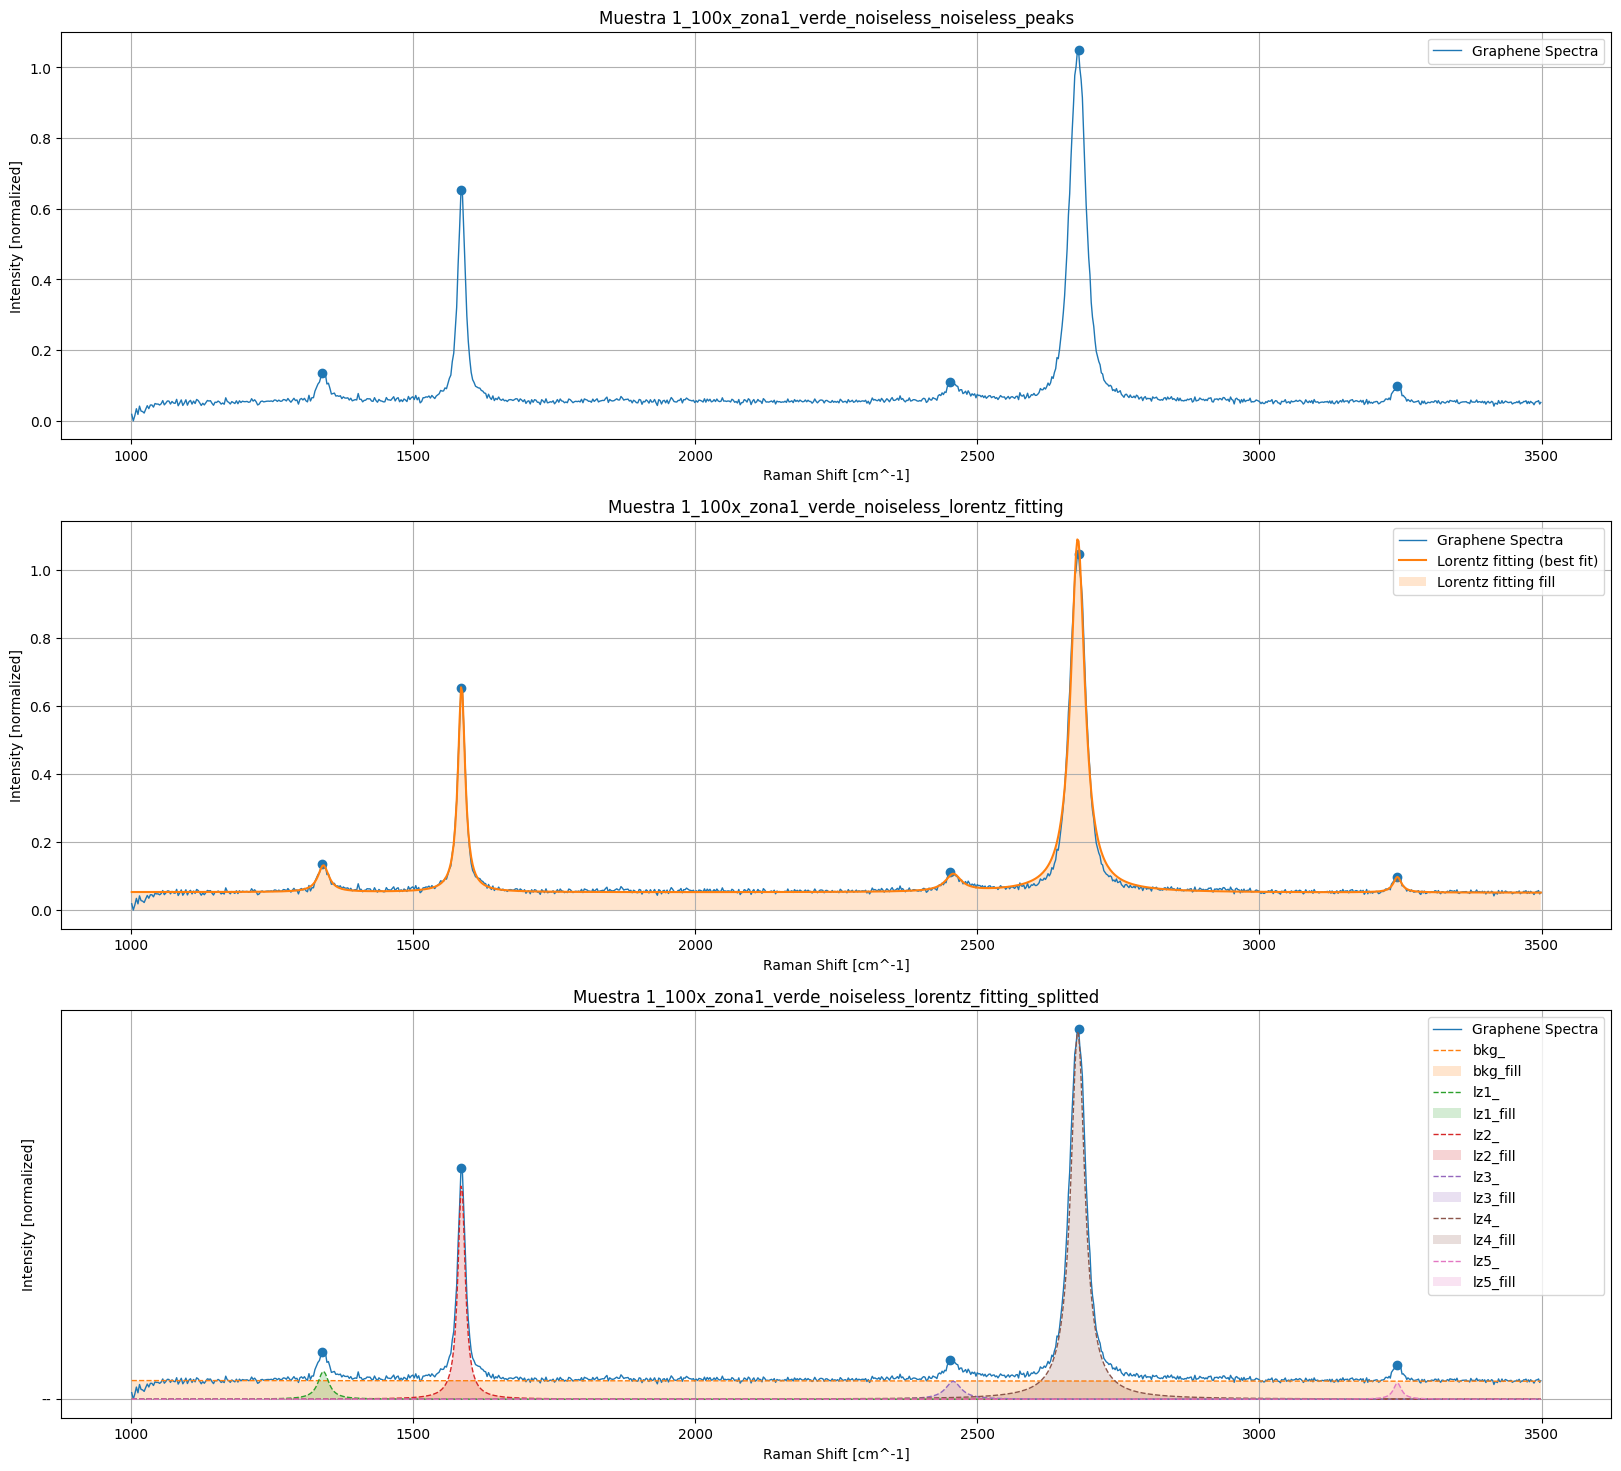

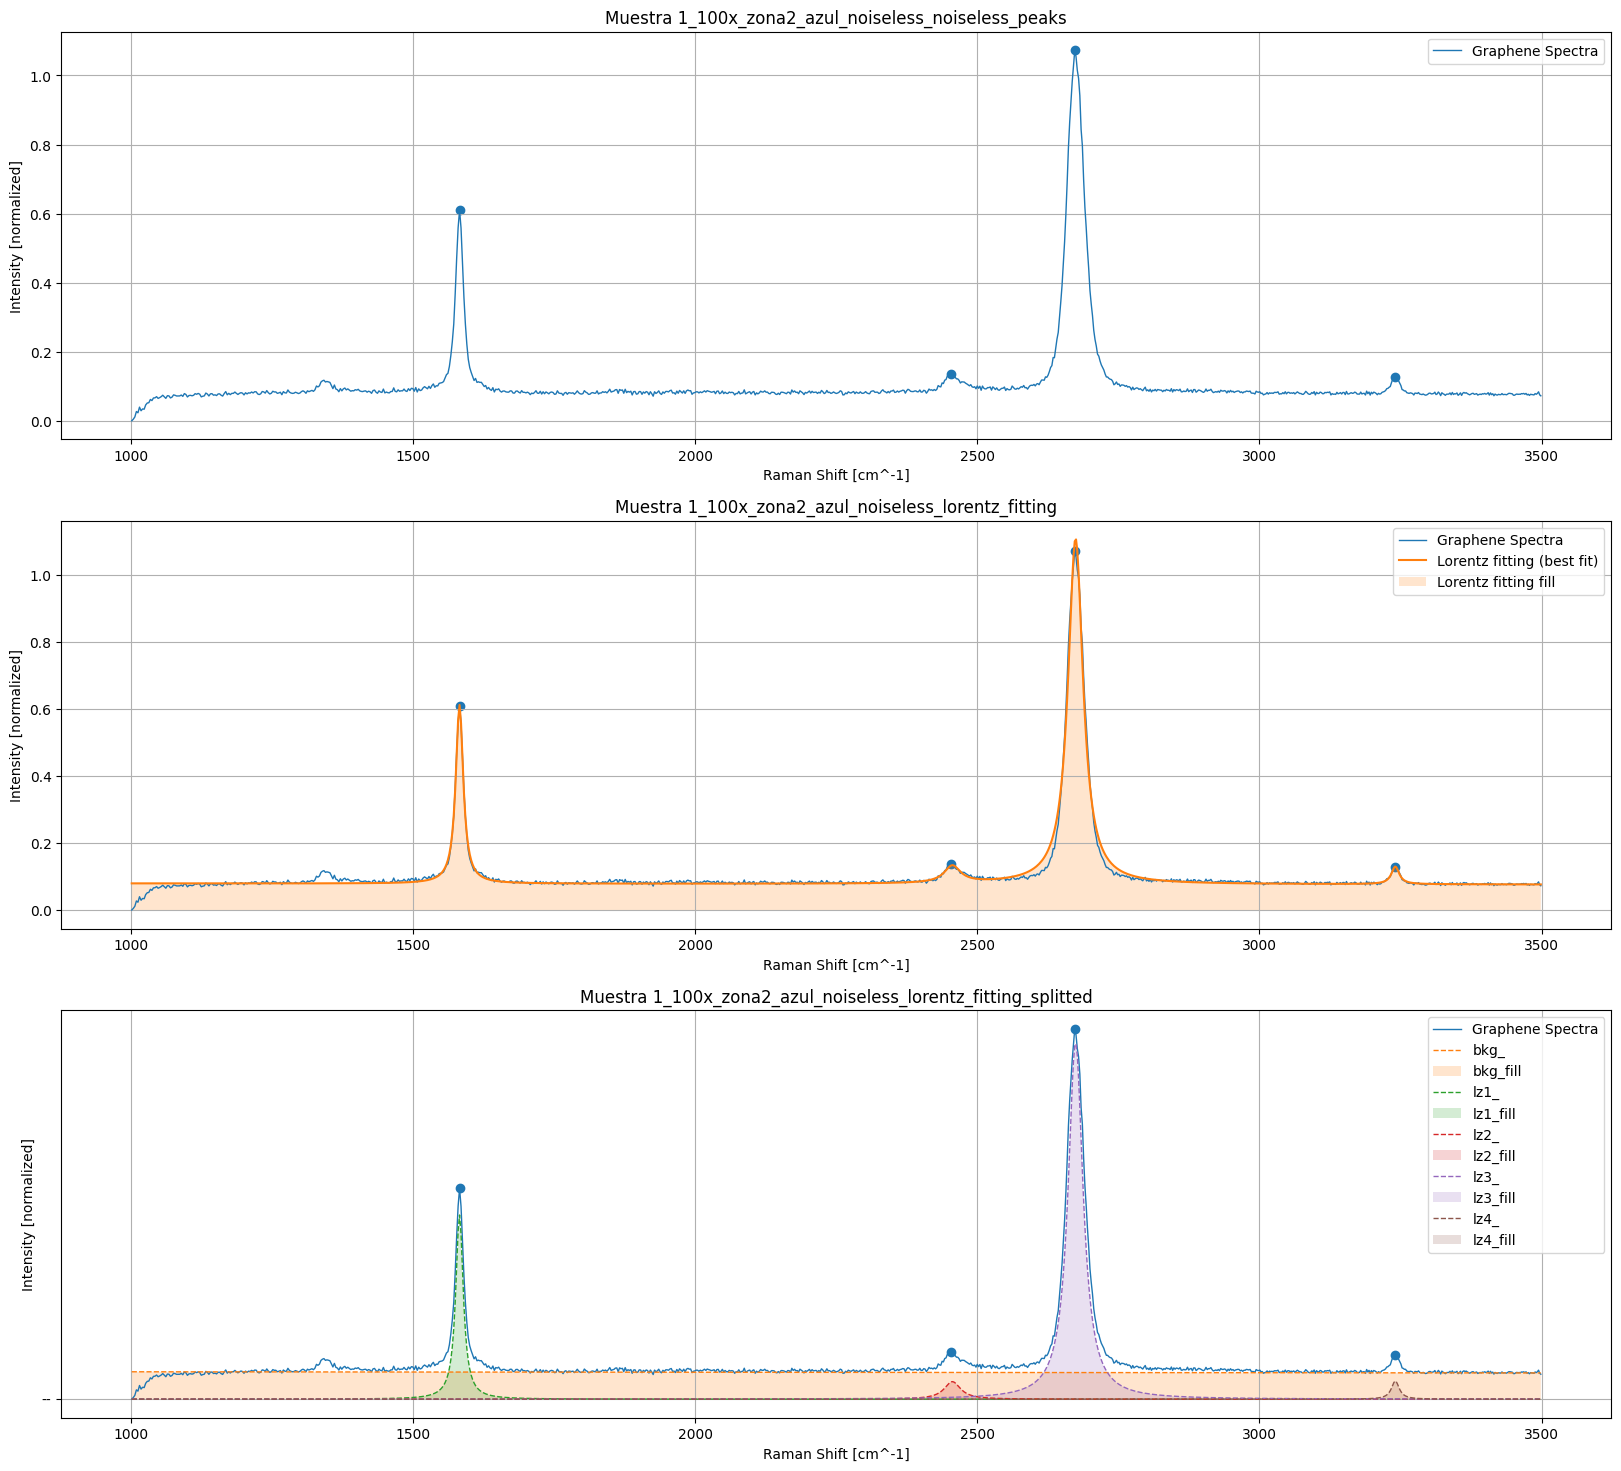

Error in callback <function flush_figures at 0x0000029079E4C400> (for post_execute), with arguments args (),kwargs {}:


In [ ]:
data_folder = '20241112_data_LUCE_ICAT'
process_data(data_folder)
analyze_data(data_folder)